# ECSE415 - Into to Computer Vision
## Assignment 4
### Alexander Harris - 260688155

## 1 - Data Acquisition

In [1]:
import cv2
import numpy as np
import os
import math
import time
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA

In [2]:
def plotFigures(images, labels=None, title=None):
    """
    Plots images from list in grid.
    
    images: list of images
    title: title for each subplot
    params: specific arguments to add to title
    """
    grid_len = math.ceil(math.sqrt(len(images)))
    plt.figure(figsize=(20,20))
    i = 0
    seq = 1
    tmp = ''
    if labels:
        for image, label in zip(images, labels):
            plt.subplot(grid_len, grid_len, i+1), plt.imshow(image, 'gray')
            if label != tmp:
                seq = 1
            plt.title(f'{label} - #{seq}'), plt.axis('off')
            tmp = label
            i += 1
            seq += 1
    else:
        for image in images:
            plt.subplot(grid_len, grid_len, i+1), plt.imshow(image, 'gray')
            plt.title(f'{title} - #{i+1}'), plt.axis('off')
            i += 1
    plt.show()

In [3]:
def extract_face(img, class_face, size):
    """
    Crop face from original image and resize.
    
    img: image to crop
    class_face: classifier to use
    """
    detect = class_face.detectMultiScale(img, 1.1, 3)
    x, y, w, h = detect[0]
    face = img[y:y+h, x:x+w]
    face_resized = cv2.resize(face, size)
    return face_resized

In [4]:
# Classifier used for testing and prepping training data
face_cascade = cv2.CascadeClassifier(os.path.join(cv2.data.haarcascades, 'haarcascade_frontalface_default.xml'))

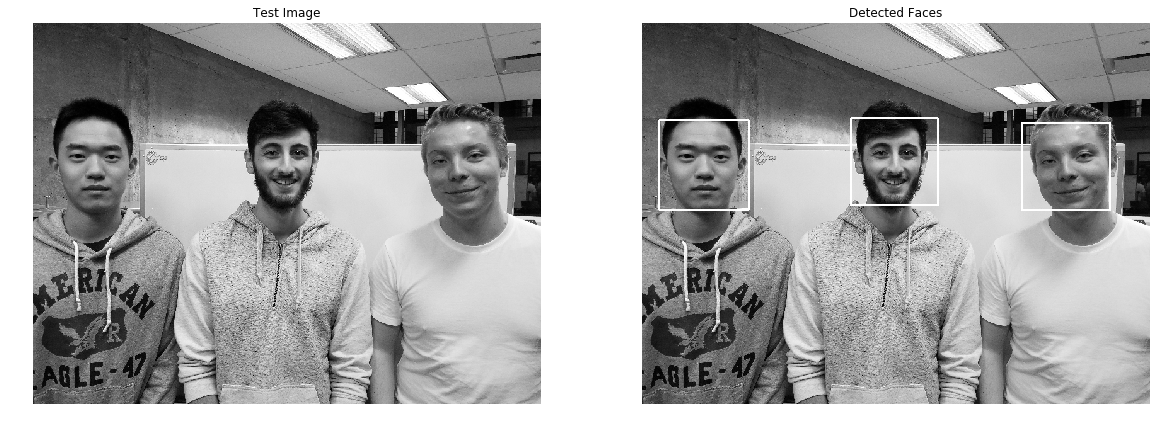

In [5]:
# Show faces detected in test image
test_path = './dataset/test/'
test_file = os.listdir(test_path)[0]
test_img_og = cv2.imread(test_path + test_file, cv2.IMREAD_GRAYSCALE)
test_img = cv2.resize(test_img_og, None, fx=0.2, fy=0.2)
test_faces = face_cascade.detectMultiScale(test_img, 1.3, 3)

face_size = (128,128)

detected_faces = test_img.copy()
test_detected_faces = []
for (x, y, w, h) in test_faces:
    cv2.rectangle(detected_faces, (x,y), (x+w,y+h), (255,255,255), 2)
    test_detected_faces.append(cv2.resize(test_img[y:y+h, x:x+w], face_size))

plt.figure(figsize=(20,20))
plt.subplot(121), plt.title('Test Image')
plt.imshow(test_img, cmap='gray'), plt.axis('off')
plt.subplot(122), plt.title('Detected Faces')
plt.imshow(detected_faces, cmap='gray'), plt.axis('off')
plt.show()

In [6]:
# Import training images and crop around faces
train_path = './dataset/train/'
train_classes = os.listdir(train_path)

train_faces = []
train_labels = []
for train_class in train_classes:
    filenames = os.listdir(train_path + train_class + '/')
    for i, file in enumerate(filenames):
        img = cv2.imread(f'{train_path}{train_class}/{file}', cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, None, fx=0.5, fy=0.5)
        face = extract_face(img, face_cascade, face_size)
        train_faces.append(face)
        train_labels.append(train_class)

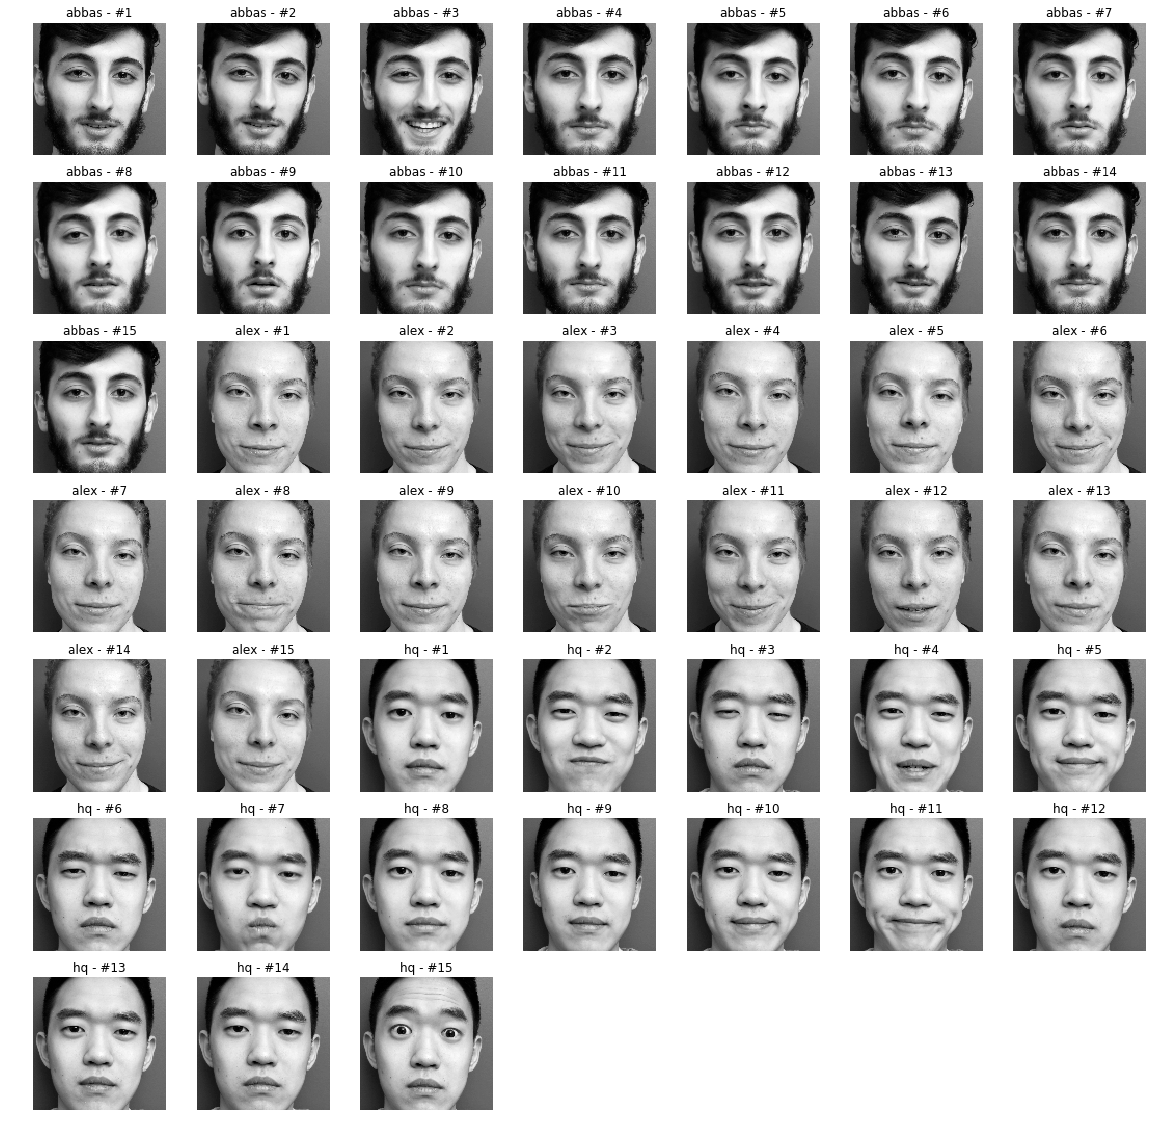

In [7]:
plotFigures(train_faces, train_labels)

**_Describe how you selected the images with respect to the conditions of the detection/classification methods_**

We decided to convert all images to grayscale in order to reduce dimensionality of our data and speed up computation time, since the method we are using the classify the faces is reliant on facial features and not color. We also decided to resize our training images to a set size in order to reduce computation time and standardize the dimensions of our training data.

When selecting our training images, we tried to keep the orientation of the face constant throughout, as well as resolution of the original images, lighting, background, etc. W e are using 15 images as opposed to the minimum 10, as we hope this will increase the accuracy

## 2 - Eigenvector Representation

In [8]:
# Convert to numpy arrays and reshape images from 2D arrays to vectors
x_train = np.float64(train_faces)
y_train = np.array(train_labels)

x_train = x_train.reshape(x_train.shape[0], -1)

In [9]:
# Compute PCA over range of components
pca_comp = range(1, x_train.shape[0]+1)
variance_ratio = []
for comp in pca_comp:
    pca = PCA(n_components=comp)

    # Compute PCA
    x_train_pca = pca.fit_transform(x_train)
    
    # Get explained variance ratio
    variance_ratio.append(pca.explained_variance_ratio_[-1])

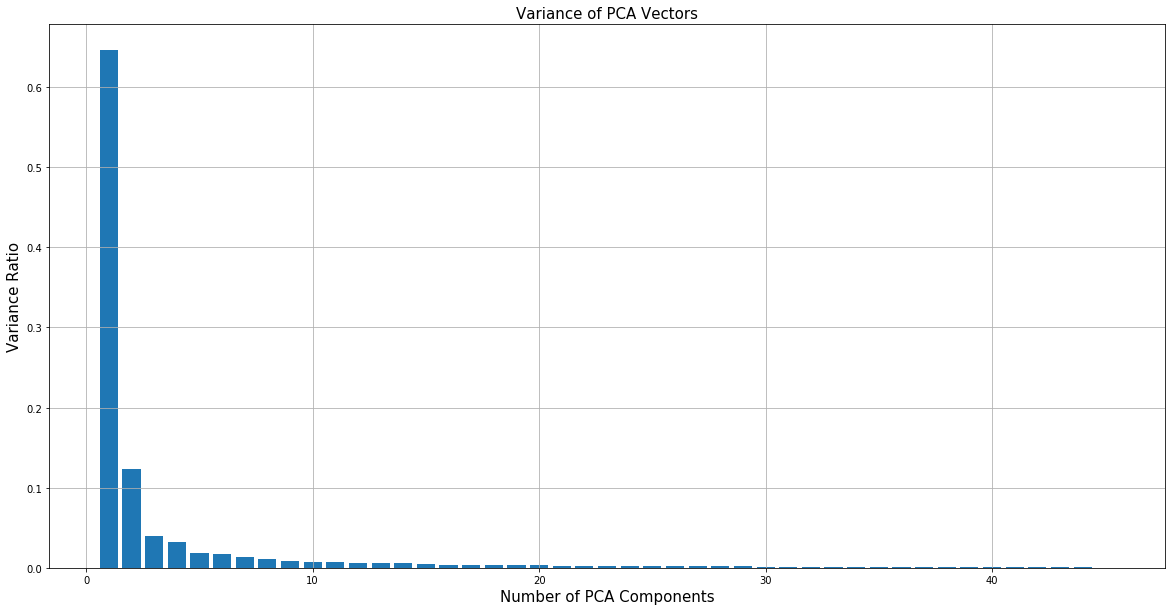

In [10]:
# Plot PCA variance ratio vs number of PCA components
plt.figure(figsize=(20,10))
plt.bar(pca_comp, variance_ratio)
plt.title('Variance of PCA Vectors', fontsize=15)
plt.xlabel('Number of PCA Components', fontsize=15)
plt.ylabel('Variance Ratio', fontsize=15)
plt.grid(True)
plt.show()

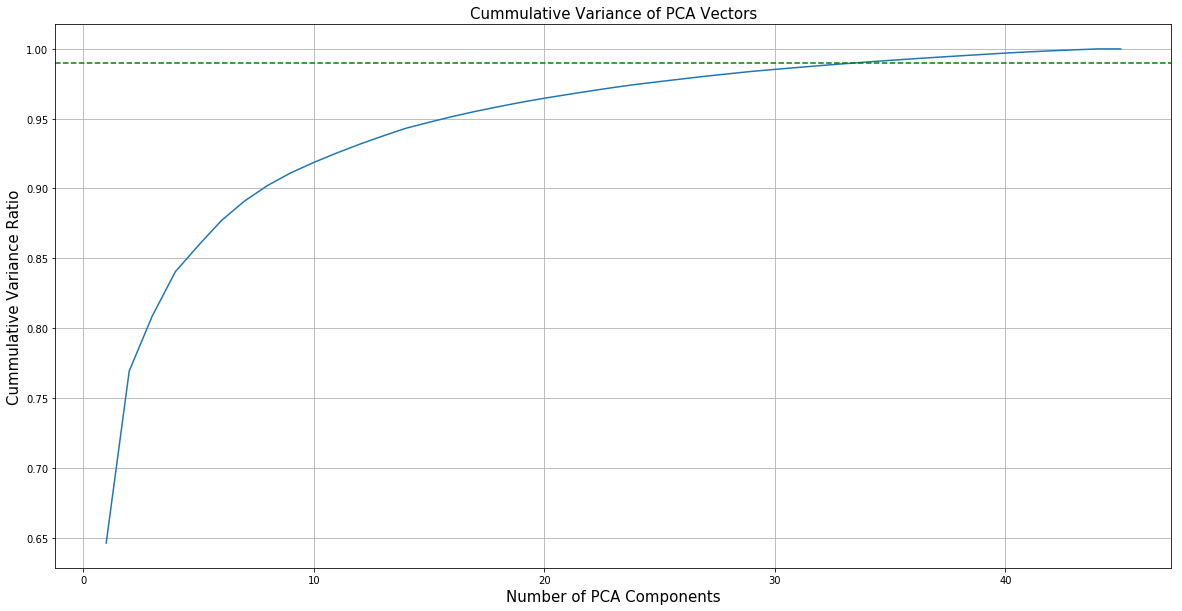

Number of components where sum(pca_var) >= 0.99: 34


In [11]:
# Plot cummulative variance and find number of components required for specified accuracy
accuracy = 0.99
n_components = 2

plt.figure(figsize=(20,10))
plt.plot(pca_comp, np.cumsum(variance_ratio))
plt.axhline(y=accuracy, color='g', linestyle='--')
plt.title('Cummulative Variance of PCA Vectors', fontsize=15)
plt.xlabel('Number of PCA Components', fontsize=15)
plt.ylabel('Cummulative Variance Ratio', fontsize=15)
plt.grid(True)
plt.show()

for i, var_sum in enumerate(np.cumsum(variance_ratio)):
    if var_sum >= accuracy:
        n_components = pca_comp[i]
        print(f'Number of components where sum(pca_var) >= {accuracy}: {n_components}')
        break

**_Do you need all vectors to represent the data?_**

No, because trying to compute vectors beyond the size of our training data set (in this case 45 images) will not yield any results and therefore the variance ratio will not change. Additionally, the variance starts off quite high for k=1 components and drops sharply until around k=10 where the decrease becomes more gradual. Therefore we should only need to compute a small subset of vectors in order to represent most of our training data, and we do not need to compute a PCA vector from every component in the training set. In our case, we will only compute PCA components up to a cummulative variance of 0.99.

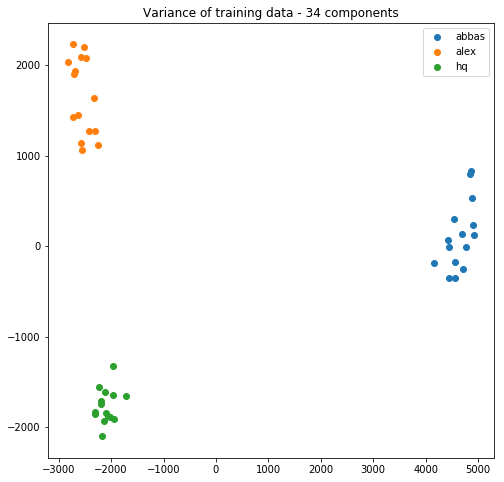

In [12]:
# Compute PCA
pca = PCA(n_components=n_components)
x_pca = pca.fit_transform(x_train)

# Select matching data and plot
plt.figure(figsize=(8,8))
for img_class in train_classes:
    x_class = x_train_pca[y_train == img_class, :]
    plt.scatter(x_class[:,0], x_class[:,1])
plt.title(f'Variance of training data - {n_components} components')
plt.legend(train_classes)
plt.show()

In [13]:
def find_nearest_neighbour(vector, vectors, idx=None):

    l2_dist = []

    for i, v in enumerate(vectors):
        if i == idx:
            l2_dist.append(float('inf'))
        else:
            l2_dist.append(np.linalg.norm(v - vector, ord=2))
    min_idx = np.argmin(l2_dist)
    
    return min_idx, l2_dist

In [14]:
def accuracy(y_pred, y_true):
    good = 0
    for i in range(len(y_true)):
        if y_pred[i] == y_true[i]:
            good += 1
            
    return good / len(y_true)

In [15]:
pred_eig = []
for i, v in enumerate(x_pca):
    min_idx, _ = find_nearest_neighbour(v, x_pca, i)
    pred_eig.append(y_train[min_idx])
    
score_eig = accuracy(pred_eig, y_train)
print(f'Eigenspace NN Accuracy: {score_eig}')

Eigenspace NN Accuracy: 1.0


In [16]:
pred_pixel = []
for i, v in enumerate(x_train):
    min_idx, _ = find_nearest_neighbour(v, x_train, i)
    pred_pixel.append(y_train[min_idx])
    
score_pixel = accuracy(pred_pixel, y_train)
print(f'Pixel-Space NN Accuracy: {score_pixel}')

Pixel-Space NN Accuracy: 1.0


In [17]:
print(f'Eigenspace dimensions: {x_pca.shape}')
print(f'Pixel-Space dimensions: {x_train.shape}')

Eigenspace dimensions: (45, 34)
Pixel-Space dimensions: (45, 16384)


**_How well-clustered is your data?_**

As we can see, there is no significant difference between the accuracy of the eigenspace and pixel space representations. However, we can say that a nearest neighbour type classification should have better performance in the eigenspace when compared to the original pixel space due to the reduced dimensionality. Namely, the eigenspace in this case has a dimensions of 34, while the image space has a dimension of 128x128 or 16 384.

## 3 - Face Detection & Identification
### 3.1 - Face Detection

In [18]:
# Get mean face and eigenfaces
face_h, face_w = face_size
mean_face = pca.mean_.reshape(face_h, face_w)
eigenfaces = pca.components_.reshape((n_components, face_h, face_w))

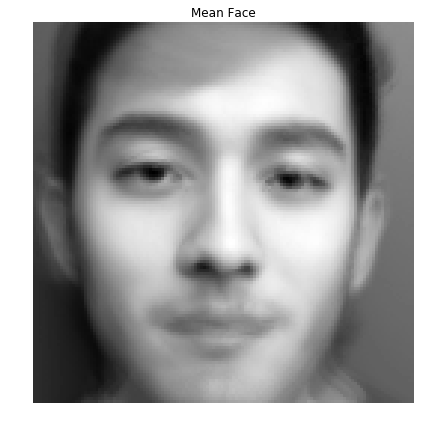

In [19]:
# Display mean face
plt.figure(figsize=(7,7))
plt.imshow(mean_face, cmap='gray')
plt.title('Mean Face'), plt.axis('off')
plt.show()

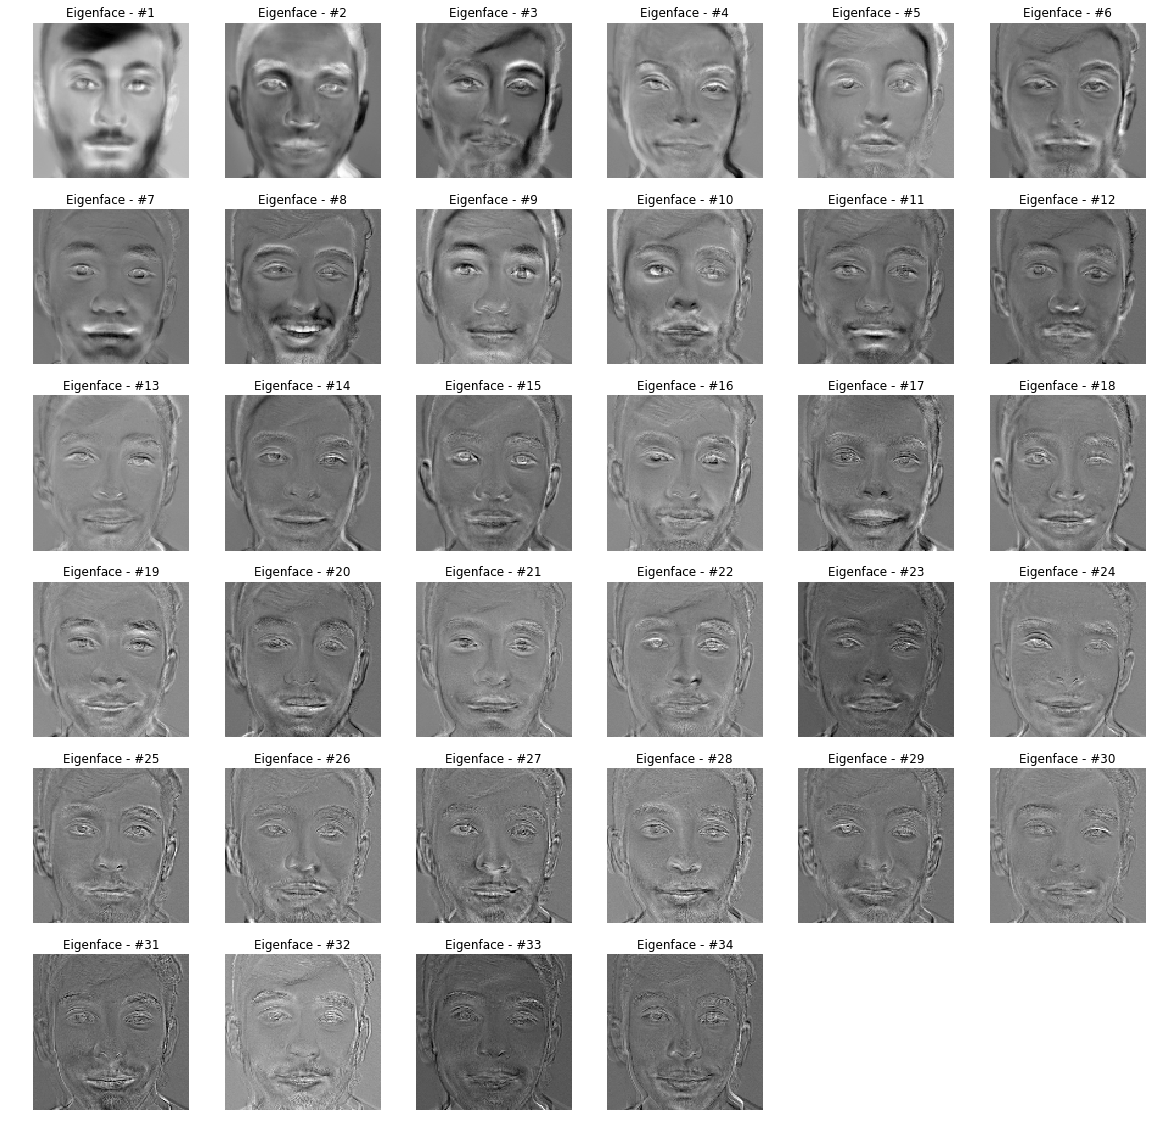

In [20]:
# Display eigenfaces
plotFigures(eigenfaces, title='Eigenface')

In [21]:
def sliding_window(img, window, step=10):
    """
    Returns image within window every iteration, then steps over.
    
    img: image to slide over
    window: size of windows to return
    step: number of pixels to move over every iteration
    """
    for y in range(0, img.shape[0], step):
        for x in range(0, img.shape[1], step):
            img_crop = img[y:y+window[1], x:x+window[0]]
            yield (x, y, img_crop)

In [22]:
def reconstruct(centered_img, mean_face, eigenfaces):
    """
    Reconstructs face in original image using eigenfaces.
    
    centered_img: mean-subtracted image vector
    mean_face: mean face vector
    eigenfaces: eigenvectors representing eigenfaces
    """
    reconstruction = mean_face
    
    for eigv in eigenfaces:
        coeff = np.dot(centered_img, eigv)
        reconstruction += eigv * coeff
        
    return reconstruction

In [23]:
# Flatten mean and eiganface vectors
mean_face_flat = mean_face.ravel()
eigenfaces_flat = eigenfaces.reshape(eigenfaces.shape[0], -1)

# Resize test image so faces fit in window
test_img = cv2.resize(test_img_og, None, fx=0.22, fy=0.22)

norms = []
win_proc = 0
win_rej = 0

start = time.time()
for (x, y, img) in sliding_window(test_img, window=face_size, step=25):
    if img.shape[0] != face_size[0] or img.shape[1] != face_size[1]:
        win_rej += 1
        continue
    
    # Center image by subtracting mean and project onto eigenspace to create reconstruction
    img_flat = img.ravel()
    centered_img = img_flat - mean_face_flat
    reconstruction = reconstruct(centered_img, mean_face_flat, eigenfaces_flat)
    
    # Compute distance between original image and reconstruction
    norm = np.linalg.norm(centered_img - reconstruction)
    
    norms.append({'norm': norm, 'image': img, 'coords': (x,y)})
    win_proc += 1

norm_vals = [x['norm'] for x in norms]
norm_min = min(norm_vals)
norm_std = np.std(np.array(norm_vals))
norm_mean = np.mean(np.array(norm_vals))
print(f'Min: {norm_min}')
print(f'Std: {norm_std}')
print(f'Mean: {norm_mean}')
print(f'Total windows: {win_proc + win_rej}')
print(f'Windows Processed: {win_proc}')
print(f'Windows Rejected: {win_rej}')
print(f'Processing time: {(time.time() - start)}')

Min: 17183.085539789256
Std: 1592.4412625104414
Mean: 20585.044493344736
Total windows: 972
Windows Processed: 682
Windows Rejected: 290
Processing time: 3.1036934852600098


In [24]:
faces_detected = []
test_image_copy = test_img.copy()

# Go through and pick distances smaller than thresh
weight = 1.54
thresh = norm_mean - norm_std * weight
for val in norms:
    norm = val['norm']
    img = val['image']
    x, y = val['coords']
    
    if norm < thresh:
        faces_detected.append(img)
        cv2.rectangle(test_image_copy, (x,y), (x+face_size[0],y+face_size[1]), (255,255,255), 2)
print(f'Faces Detected: {len(faces_detected)}')

Faces Detected: 6


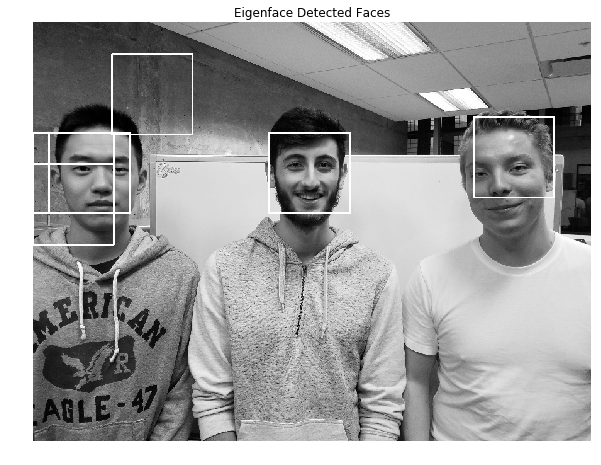

In [25]:
# Display detected faces
plt.figure(figsize=(10,10))
plt.imshow(test_image_copy, cmap='gray')
plt.title('Eigenface Detected Faces'), plt.axis('off')
plt.show()

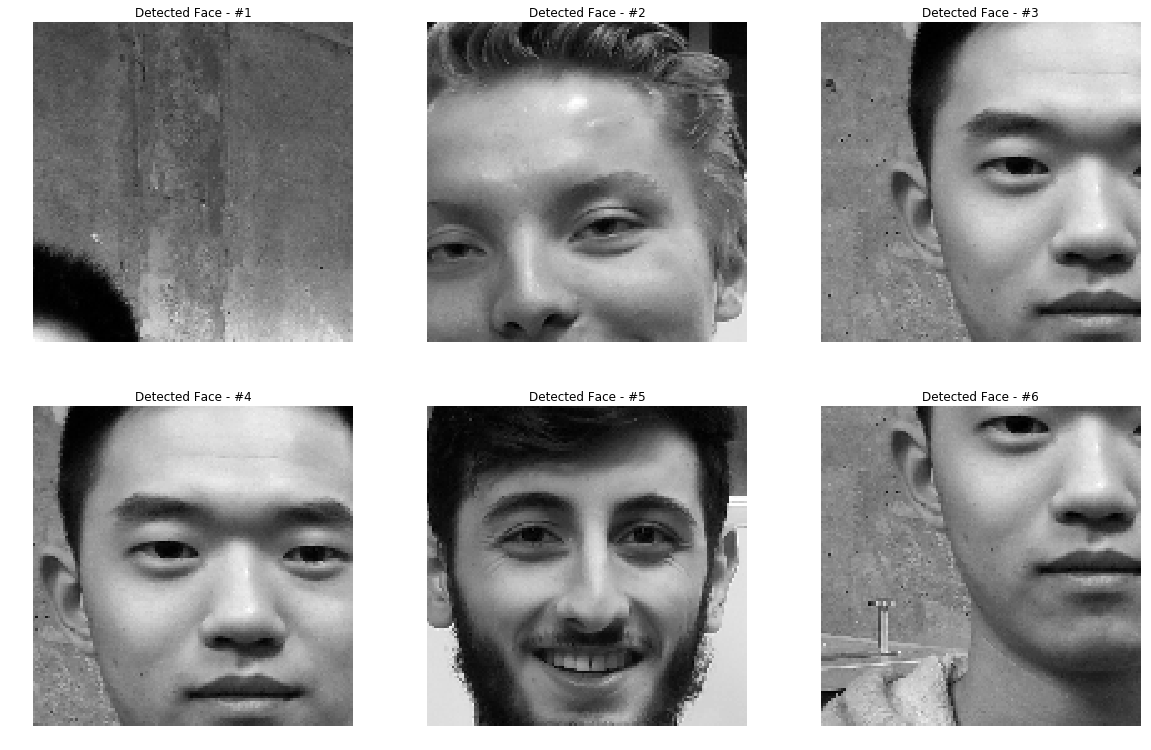

In [26]:
plotFigures(faces_detected, title='Detected Face')

Here we can see that while this method of facial detection works, it can be quite inacurate and can generate a lot of false positives if the threshold is not chosen correctly. Additionally, it requires that faces in the picture be as close to the training set as possible, and any variation in head position or orientation within the window could result in a false negative.

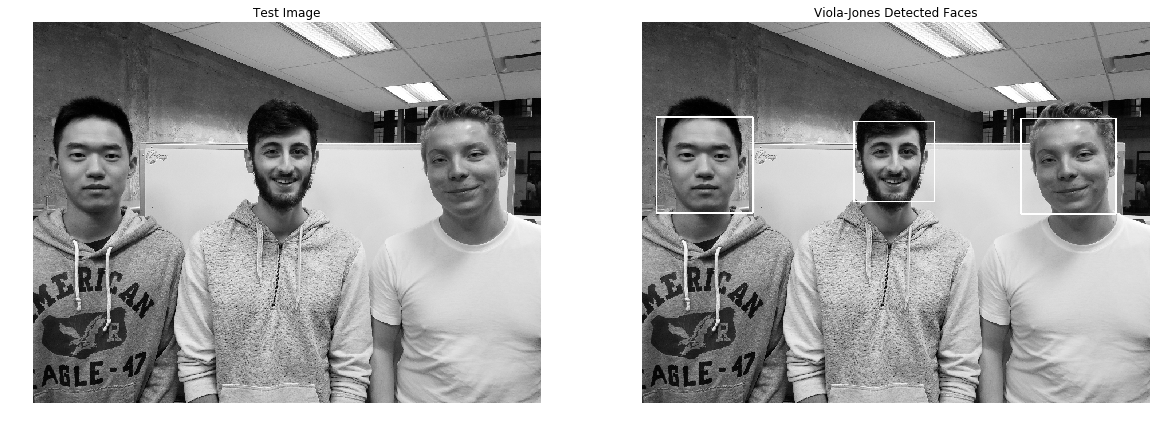

In [27]:
# Get faces for facial recognition
# Will use Viola-Jones to get good faces and compare results with my own facial detection
test_faces = face_cascade.detectMultiScale(test_img, 1.3, 3)

detected_faces = test_img.copy()
test_detected_faces = []
for (x, y, w, h) in test_faces:
    cv2.rectangle(detected_faces, (x,y), (x+w,y+h), (255,255,255), 2)
    test_detected_faces.append(cv2.resize(test_img[y:y+h, x:x+w], face_size))
    
plt.figure(figsize=(20,20))
plt.subplot(121), plt.title('Test Image')
plt.imshow(test_img, cmap='gray'), plt.axis('off')
plt.subplot(122), plt.title('Viola-Jones Detected Faces')
plt.imshow(detected_faces, cmap='gray'), plt.axis('off')
plt.show()

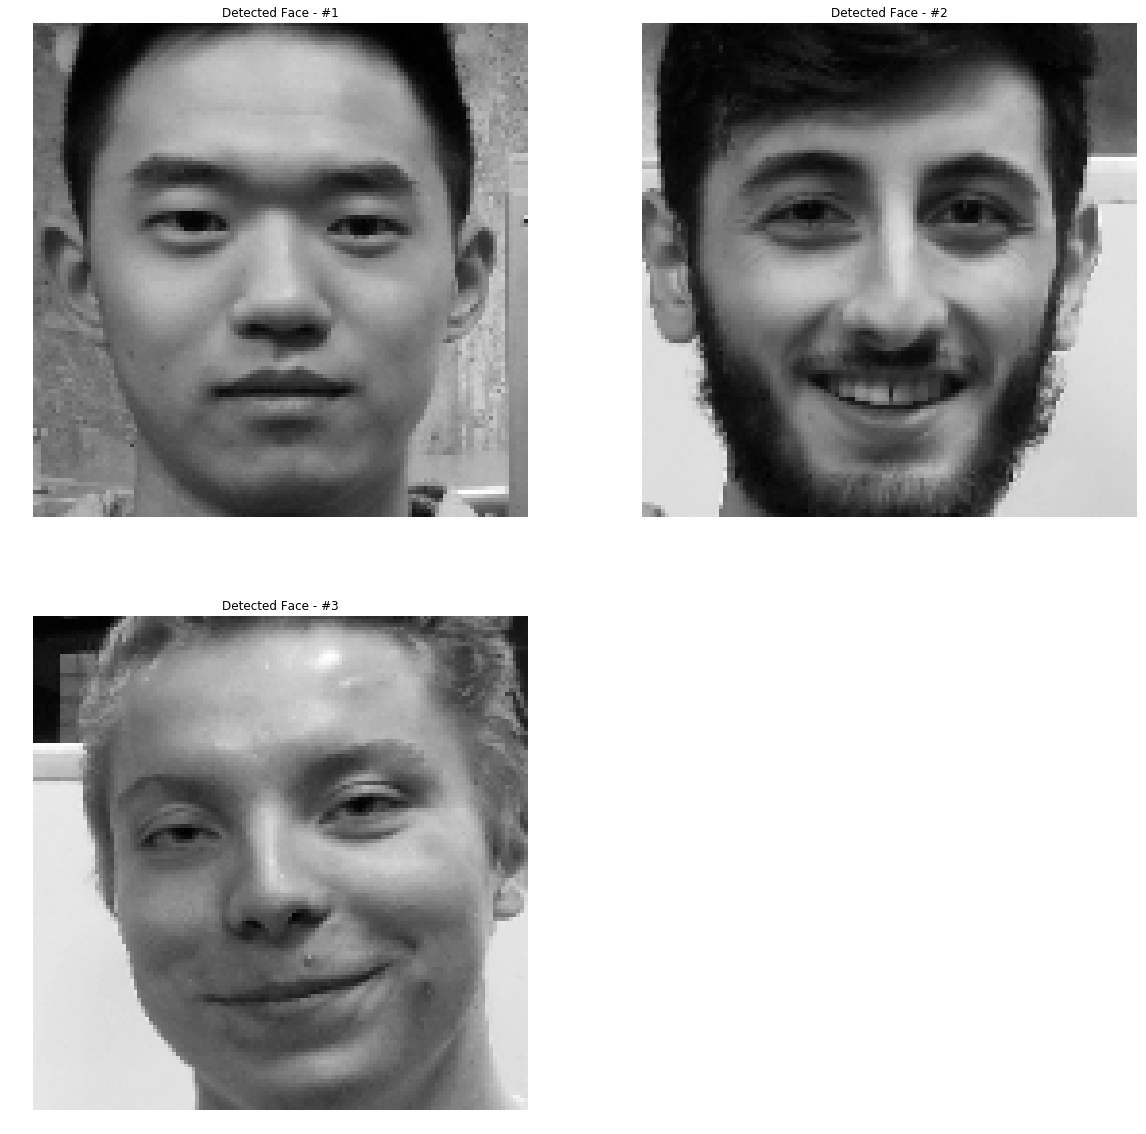

In [28]:
plotFigures(test_detected_faces, title='Detected Face')

### 3.2 - Face Identification

In [29]:
# Flatten image vectors
test_detected_faces = np.array(test_detected_faces)
test_detected_faces = test_detected_faces.reshape(test_detected_faces.shape[0], -1)
faces_detected = np.array(faces_detected)
faces_detected = faces_detected.reshape(faces_detected.shape[0], -1)

x_pca = pca.fit_transform(x_train)
test_eigenfaces = pca.transform(test_detected_faces)
x_pca = pca.fit_transform(x_train)
detected_eigenfaces = pca.transform(faces_detected)

test_pred = []
for eigenface in test_eigenfaces:
    min_idx, _ = find_nearest_neighbour(eigenface, x_pca)
    test_pred.append(y_train[min_idx])
print(f'Prediction for Haar Cascade faces: {test_pred}')

detect_pred = []
for eigenface in detected_eigenfaces:
    min_idx, _ = find_nearest_neighbour(eigenface, x_pca)
    detect_pred.append(y_train[min_idx])
print(f'Prediction for Eigenface detection faces: {detect_pred}')

Prediction for Haar Cascade faces: ['hq', 'abbas', 'alex']
Prediction for Eigenface detection faces: ['abbas', 'alex', 'alex', 'alex', 'abbas', 'alex']


We can see that for the faces obtained from the Haar Cascade, we have 100% accuracy, while for the faces obtained from our own facial detection scheme, we are only able to correctly classify 40% of the faces. This can be attributed to not having the entire face displayed within the captured window. This method really only works properly for very carefully chosen test images, and does not perform well when we introduce sources of error such as changes in orientation, lighting, background and image size.

When it comes to false positives in facial detection, we were able to tweak things such as our threshold, window size, test image size and step size until we eliminated a large amount, however this did not completely eradicate the problem and the algorithm notably has difficulty capturing complete faces in our test image. This may be due to differences in head size between the three subjects, as well as small changes in posture. Again this highlights the flaws of this facial detection method as it is not generalizable to other image sets.

Eigenfaces fails most often when image sizes are not consistent and when there is notable occlusion due to changes in posture and head orientation. Our method could be improved by using a variable-sized sliding window to deal with different face shapes/sizes, as well as training on a much larger dataset with changes in head position, expression, etc.

## 4 - Viola-Jones Comparison

The differences between the Viola-Jones face detector and our implementation can be seen above as we used it to test our facial recognition alongside our own method. We can see that by setting the number of neighbours to 3 we were able to detect all the faces in our test image with no false positives. The detected faces also did not have the cutoff problems seen in our eigenfaces implementation. Viola Jones should work under different lighting conditions, different image sizes, and even in cases where there is occlusion around the face, areas where eigenfaces would fail most of the time.

We also noticed that Viola-Jones has a lot less false positives than our implementation, and therefore does not require that we spend extra time tweaking parameters trying to reduce them.